In [128]:
import re                                                                                        
import numpy as np                                       
import pandas as pd                                       
from matplotlib import pyplot as plt                      
import seaborn as sns
plt.style.use('ggplot')
from wordcloud import WordCloud                          
from sklearn.model_selection import train_test_split
import spacy
import preprocess_kgptalkie as kgp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix
nlp = spacy.load('en_core_web_sm')  
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout
from keras.layers import MaxPooling1D, GlobalMaxPooling1D,Conv1D

from ktrain import text
import ktrain


In [129]:
# load train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [130]:
train_df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [46]:
train_df.shape

(7613, 5)

Text(0.5, 1.0, 'Target Distribution')

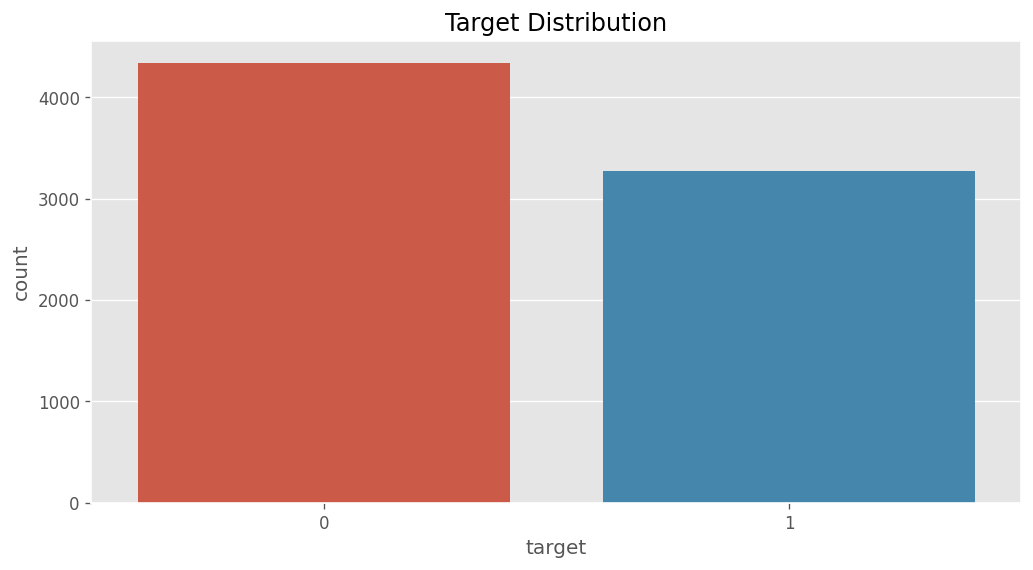

In [47]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 120  
sns.countplot(x='target', data=train_df)
plt.title('Target Distribution')

<Axes: ylabel='count'>

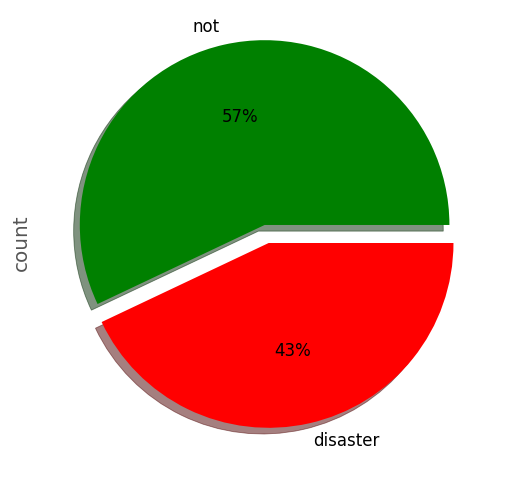

In [48]:
train_df['target'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["green", "red"], labels=["not", "disaster"], explode=(0.1, 0), shadow=True)

In [49]:

kgp.get_basic_features(train_df)
train_df.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


<Axes: xlabel='char_counts', ylabel='Count'>

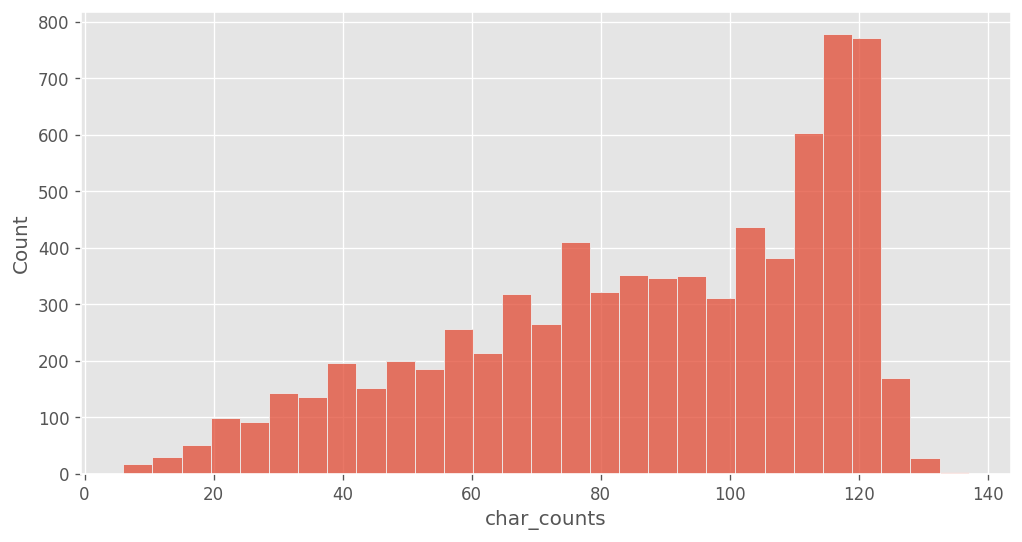

In [50]:
sns.histplot(train_df['char_counts'])

<Axes: xlabel='char_counts', ylabel='Density'>

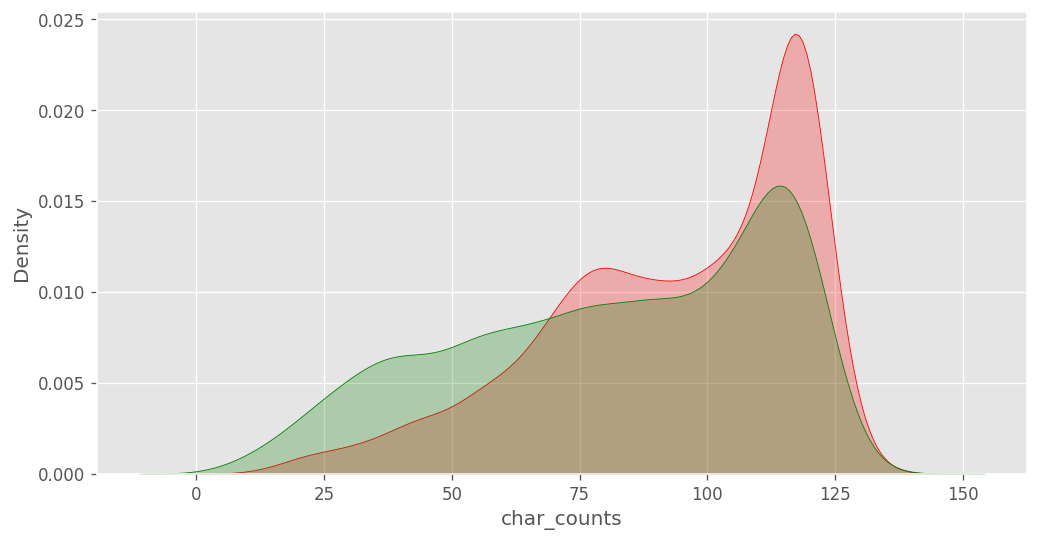

In [51]:
sns. kdeplot(train_df[train_df[ 'target']==1]['char_counts'], fill=True,color='red')
sns. kdeplot(train_df[train_df[ 'target']==0]['char_counts'], fill=True,color='green')

<Axes: xlabel='word_counts', ylabel='Density'>

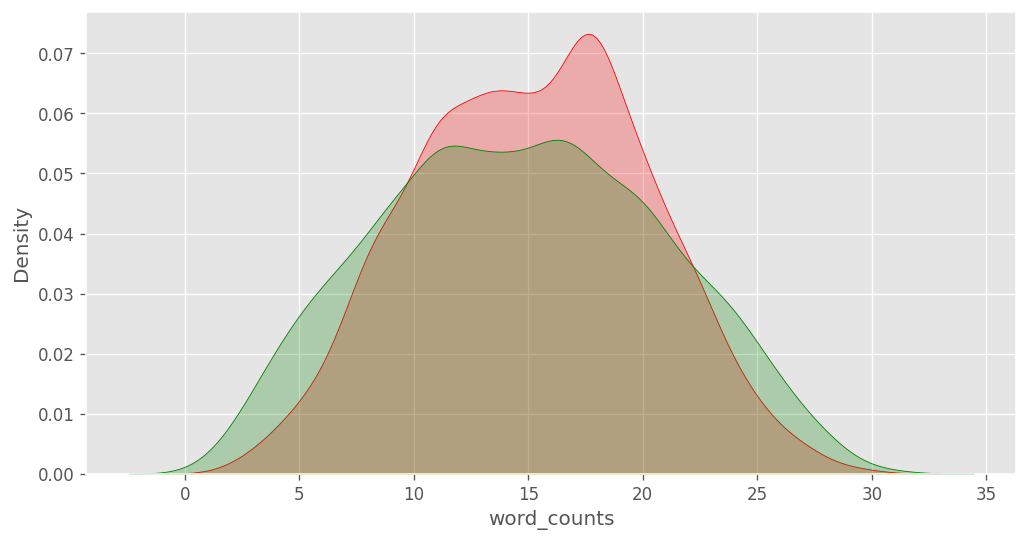

In [52]:
sns. kdeplot(train_df[train_df[ 'target']==1]['word_counts'], fill=True,color='red')
sns. kdeplot(train_df[train_df[ 'target']==0]['word_counts'], fill=True,color='green')

In [53]:
freqs = kgp.get_word_freqs(train_df,'text')

In [54]:
top20 = freqs[100:120]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'back'),
  Text(1, 0, 'see'),
  Text(2, 0, '@YouTube'),
  Text(3, 0, 'go'),
  Text(4, 0, '3'),
  Text(5, 0, 'Is'),
  Text(6, 0, 'RT'),
  Text(7, 0, 'THE'),
  Text(8, 0, 'time'),
  Text(9, 0, 'disaster'),
  Text(10, 0, 'think'),
  Text(11, 0, 'buildings'),
  Text(12, 0, 'Full'),
  Text(13, 0, 'bomb'),
  Text(14, 0, 'suicide'),
  Text(15, 0, 'want'),
  Text(16, 0, 'body'),
  Text(17, 0, 'Emergency'),
  Text(18, 0, 'How'),
  Text(19, 0, 'down')])

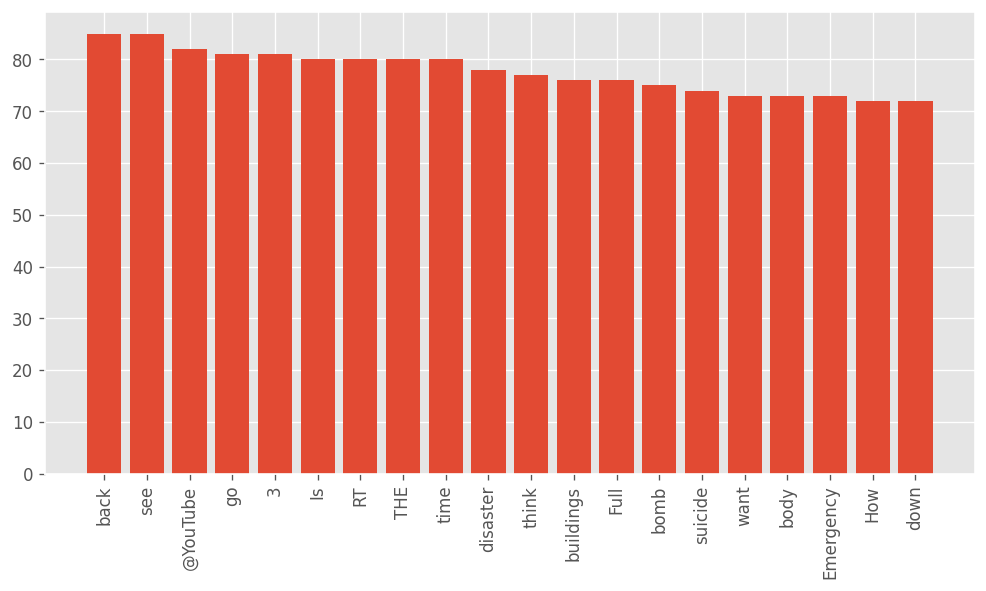

In [55]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=90)

In [56]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_',' '). replace('.',' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [57]:
train_df['text'] = train_df['text'].apply(lambda x: get_clean(x))

/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


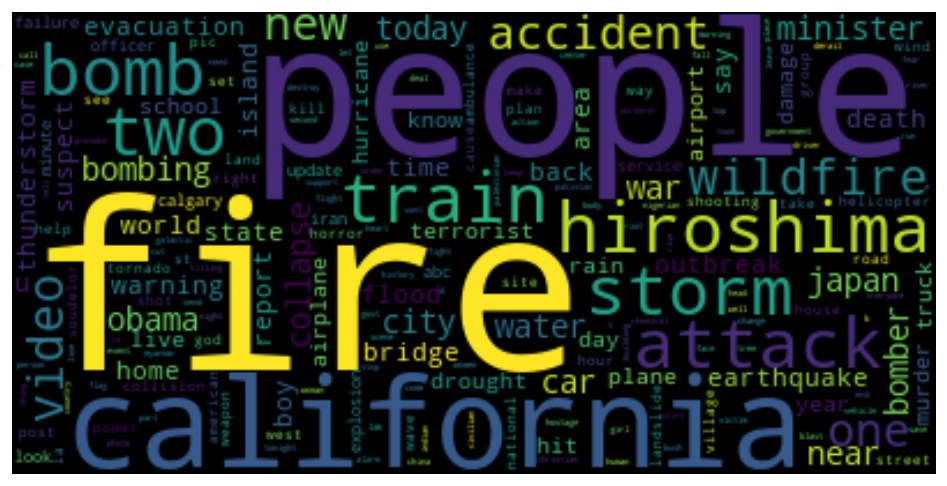

In [58]:
disaster = kgp.get_word_freqs(train_df[train_df['target']==1], 'text')
disaster = ' '.join(disaster.index)
cloud_word = WordCloud(max_font_size=100).generate(disaster)
plt.imshow(cloud_word, interpolation='bilinear')
plt.axis('off')
plt.show()


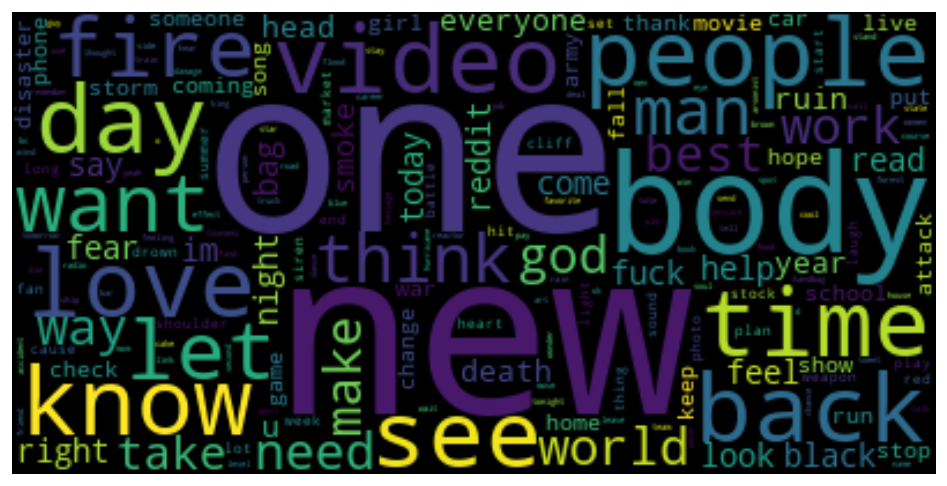

In [59]:
not_disaster = kgp.get_word_freqs(train_df[train_df['target']==0], 'text')
not_disaster = ' '.join(not_disaster.index)
cloud_word = WordCloud(max_font_size=100).generate(not_disaster)
plt.imshow(cloud_word, interpolation='bilinear')
plt.axis('off')
plt.show()


In [60]:
text = train_df['text']
y = train_df['target']

In [61]:
TF_idf = TfidfVectorizer()
x = TF_idf.fit_transform(text)

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0,stratify=y)

In [63]:
def run_SVM( clf, x_train, x_test, y_train, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    print('classification report: ')
    print(classification_report(y_test, y_pred))
    return y_pred

In [64]:
clf = LinearSVC()
run_SVM(clf, x_train, x_test, y_train, y_test)

classification report: 
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



array([0, 0, 0, ..., 1, 1, 1])

In [65]:
def vectorize_text(word):
    the_word = nlp(word)
    vectorized = the_word.vector
    return vectorized
    

In [66]:
train_df['text_vector'] = train_df['text'].apply(lambda x: vectorize_text(x))

In [67]:
train_df.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,text_vector
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.38043573, -0.18209742, -0.02168273, 0.1568..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[0.07400591, -0.656097, 0.013855262, -0.017741..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[0.17355376, -0.20632371, 0.04690058, 0.262372..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[0.19240497, -0.13486807, -0.25598165, 0.30610..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[0.5655104, -0.34887487, 0.13329165, 0.2068242..."


In [68]:
new_x = train_df['text_vector'].to_numpy()
new_x = new_x.reshape(-1, 1)

In [69]:
new_x = np.concatenate(np.concatenate(new_x, axis=0), axis=0).reshape(-1, 96)

In [70]:
x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=0.2, random_state=0,stratify=y)

In [71]:
clf = LinearSVC()
run_SVM(clf, x_train, x_test, y_train, y_test)

classification report: 
              precision    recall  f1-score   support

           0       0.71      0.78      0.74       869
           1       0.66      0.59      0.62       654

    accuracy                           0.70      1523
   macro avg       0.69      0.68      0.68      1523
weighted avg       0.69      0.70      0.69      1523



/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([0, 0, 0, ..., 0, 1, 1])

In [72]:
token = Tokenizer()
token.fit_on_texts(text)
vocab_size = len(token.word_index) + 1
encoded_text = token.texts_to_sequences(text)

In [73]:
encoded_text

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41],
 [186, 43, 223, 763, 6792, 6793, 1328],
 [41,
  1682,
  1435,
  5,
  2062,
  4,
  655,
  22,
  125,
  6794,
  19,
  1683,
  42,
  438,
  253,
  58,
  2062,
  4,
  655,
  1329,
  22,
  1054],
 [2809, 56, 4493, 1330, 253, 1329, 4, 86],
 [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189],
 [2810,
  391,
  86,
  1554,
  793,
  829,
  4,
  637,
  6797,
  534,
  5,
  1106,
  372,
  43,
  4494,
  1330],
 [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555],
 [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495],
 [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703],
 [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354],
 [586, 56, 611, 23, 2, 283, 467, 32, 612],
 [833,
  613,
  2811,
  9,
  217,
  2812,
  3467,
  656,
  3,
  657,
  7,
  199,
  4,
  613,
  2811,
  57,
  31,
  7,
  301,
  27,
  57,
  31,
  7,
  301,
  27,
  6799,
  247],
 [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 

In [74]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')


In [75]:
X.shape

(7613, 40)

In [76]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)
clf = LinearSVC()
run_SVM(clf, x_train, x_test, y_train, y_test)

classification report: 
              precision    recall  f1-score   support

           0       0.59      0.88      0.70       869
           1       0.52      0.18      0.27       654

    accuracy                           0.58      1523
   macro avg       0.56      0.53      0.49      1523
weighted avg       0.56      0.58      0.52      1523



/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([0, 0, 0, ..., 1, 0, 1])

In [79]:
vector_size =100 

model = Sequential()
model.add(Embedding(vocab_size, vector_size))
# model.add(Embedding(input_dim=vocab_size, output_dim=vector_size, input_length=max_length))  # Specify input_length here

# model.add(Embedding(input_dim=vocab_size, output_dim=vector_size))  # No need to specify input_length

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.build(max_length)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test))
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))




Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5680 - loss: 0.6775 - val_accuracy: 0.7603 - val_loss: 0.5380
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7874 - loss: 0.4855 - val_accuracy: 0.7905 - val_loss: 0.4642
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8793 - loss: 0.3087 - val_accuracy: 0.7991 - val_loss: 0.4598
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9270 - loss: 0.2016 - val_accuracy: 0.7833 - val_loss: 0.4989
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9626 - loss: 0.1213 - val_accuracy: 0.7669 - val_loss: 0.5873
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9755 - loss: 0.0764 - val_accuracy: 0.7702 - val_loss: 0.6485
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9777 - loss: 0.0576 - val_accuracy: 0.7708 - val_loss: 0.7063
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9880 - loss: 0.0404 - val_accuracy: 0.

In [80]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     2,258,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,798,401 (25.93 MB)

 Trainable params: 2,266,133 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,532,268 (17.29 MB)

In [81]:
def get_encoded(input):
    x = get_clean(input)
    x = token.texts_to_sequences([x])
    x = pad_sequences(x, maxlen=max_length, padding='post')
    return x


In [85]:
(x_train,y_train),(x_test,y_test), preproc = text.texts_from_df(train_df=train_df,text_column='text',label_columns='target',maxlen=40,preprocess_mode='bert')

['not_target', 'target']
      not_target  target
4280         1.0     0.0
2209         1.0     0.0
2229         1.0     0.0
127          1.0     0.0
134          1.0     0.0
['not_target', 'target']
      not_target  target
4826         0.0     1.0
4232         0.0     1.0
3065         0.0     1.0
3960         0.0     1.0
6053         0.0     1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [86]:
model = text.text_classifier(name='bert',train_data=(x_train,y_train),preproc=preproc)

Is Multi-Label? False
maxlen is 40


/Users/hossamfarid/anaconda3/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


In [89]:
learner = ktrain.get_learner(model=model,train_data=(x_train,y_train),val_data=(x_test,y_test),batch_size=64)

In [91]:
learner.fit_onecycle(lr=2e-4,epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 341s 3s/step - loss: 0.4128 - accuracy: 0.8248 - val_loss: 0.4058 - val_accuracy: 0.8241
Epoch 2/3
108/108 [==============================] - 400s 4s/step - loss: 0.3406 - accuracy: 0.8678 - val_loss: 0.4286 - val_accuracy: 0.8241
Epoch 3/3
108/108 [==============================] - 353s 3s/step - loss: 0.1768 - accuracy: 0.9390 - val_loss: 0.4813 - val_accuracy: 0.8320


In [93]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [132]:
prdictions_train_data = train_df['text'].apply(lambda x: predictor.predict(x,return_proba=False))
prdictions_test_data =test_df['text'].apply(lambda x: predictor.predict(x,return_proba=False))

In [131]:
# this takes more then 500 sec on avg 

In [152]:
prdictions_train_data = pd.DataFrame(prdictions_train_data)
prdictions_test_data  = pd.DataFrame(prdictions_test_data)
prdictions_train_data['text'] = prdictions_train_data['text'].replace({'target': 1, 'not_target': 0})
prdictions_test_data['text']  = prdictions_test_data['text'].replace({'target': 1, 'not_target': 0})

prdictions_train_data.insert(0, 'id', train_df['id'])
prdictions_test_data.insert(0, 'id', test_df['id'])



Text(0.5, 1.0, 'Target Distribution')

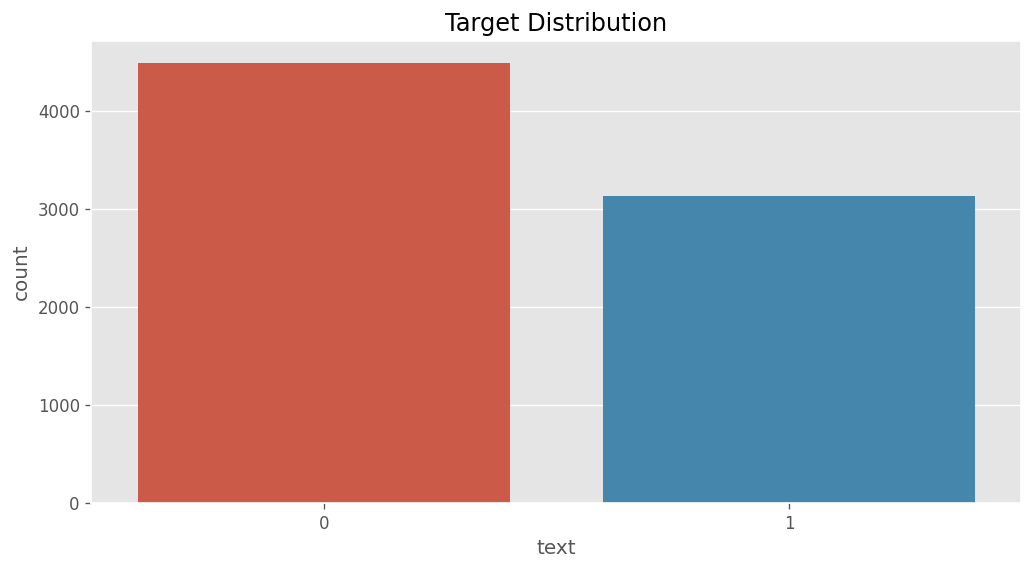

In [144]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 120  
sns.countplot(x='text',data=prdictions_train_data)
plt.title('Target Distribution')

Text(0.5, 1.0, 'Target Distribution')

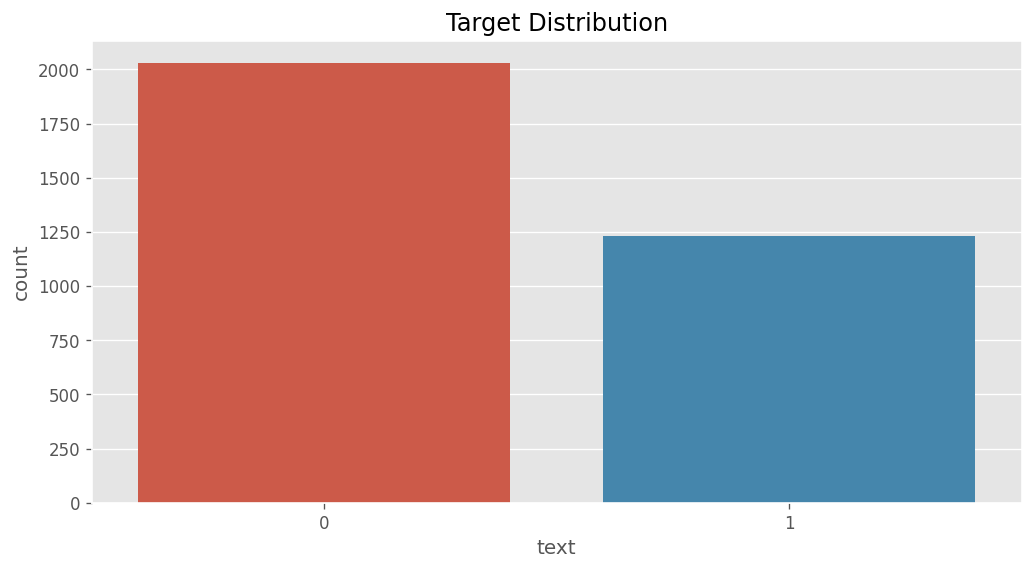

In [145]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 120  
sns.countplot(x='text',data=prdictions_test_data)
plt.title('Target Distribution')

In [155]:
# prdictions_test_data.to_csv('sample.csv', index=False)
prdictions_test_data[['id', 'text']].to_csv('sample.csv', index=True)


In [153]:
prdictions_test_data


,id,text
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,0
